In [1]:
import csv
import cv2
import numpy as np

lines = []

with open('./new_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [2]:
def process_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

In [3]:
car_images = []
steering_angles = []
for row in lines[1:]:
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.18 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = '' # fill in the path to your training IMG directory
    
    img_center = process_img(cv2.imread(path + row[0].replace(" ", "")))
    img_center_fliped = np.fliplr(img_center)
    img_left = process_img(cv2.imread(path + row[1].replace(" ", "")))
    img_left_fliped = np.fliplr(img_left)
    img_right = process_img(cv2.imread(path + row[2].replace(" ", "")))
    img_right_fliped = np.fliplr(img_right)

    # add images and angles to data set
    car_images.extend([img_center, img_left, img_right, img_center_fliped, img_left_fliped, img_right_fliped])
    steering_angles.extend([steering_center, steering_left, steering_right, -1.0 * steering_center, -1.0 * steering_left, -1.0 * steering_right])

In [4]:
from sklearn.model_selection import train_test_split
X_train = np.array(car_images)
del car_images
y_train = np.array(steering_angles)
del steering_angles
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2333)

In [5]:
import keras
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.activations import *

image_shape = X_train[0].shape

model = Sequential()
model.add(Lambda(lambda x: x / 225.0 - 0.5, input_shape=image_shape))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Conv2D(24, (5,5), strides=(2,2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(24, (5,5), strides=(2,2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32, (5,5), strides=(2,2), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32, (3,3), strides=(1,1), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(64, (3,3), strides=(1,1), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(50,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', lr=0.00001)

Using TensorFlow backend.


In [6]:
import matplotlib.pyplot as plt
#from keras.utils.vis_utils import plot_model
#from IPython.display import Image
#plt.rcParams['figure.figsize'] = (3, 1)
#plot_model(model, to_file='model.png', show_shapes=True)
#Image(filename = 'model.png')

In [7]:
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
#model = load_model('./models/orig/final_model.h5')

filepath="./models/t1/weights-improvement-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_object = model.fit(X_train,
                           y_train,
                           batch_size=64,
                           validation_split=0.2,
                           epochs=80,
                           shuffle=True,
                           callbacks=callbacks_list)

/home/meirtz/anaconda3/envs/dl_dev/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 52171 samples, validate on 13043 samples
Epoch 1/80
52171/52171 [==============================] - 64s - loss: 0.6597 - val_loss: 0.0933
Epoch 2/80
52171/52171 [==============================] - 62s - loss: 0.0647 - val_loss: 0.0582
Epoch 3/80
52171/52171 [==============================] - 63s - loss: 0.0527 - val_loss: 0.0528
Epoch 4/80
52171/52171 [==============================] - 62s - loss: 0.0516 - val_loss: 0.0581
Epoch 5/80
52171/52171 [==============================] - 63s - loss: 0.0515 - val_loss: 0.0545
Epoch 6/80
52171/52171 [==============================] - 63s - loss: 0.0523 - val_loss: 0.0543
Epoch 7/80
52171/52171 [==============================] - 63s - loss: 0.0522 - val_loss: 0.0571
Epoch 8/80
52171/52171 [==============================] - 63s - loss: 0.0529 - val_loss: 0.0558
Epoch 9/80
52171/52171 [==============================] - 63s - loss: 0.0519 - val_loss: 0.0543
Epoch 10/80
52171/52171 [==============================] - 63s - loss: 0.0516 - val_lo

52171/52171 [==============================] - 62s - loss: 0.0290 - val_loss: 0.0318
Epoch 72/80
52171/52171 [==============================] - 63s - loss: 0.0291 - val_loss: 0.0336
Epoch 73/80
52171/52171 [==============================] - 62s - loss: 0.0290 - val_loss: 0.0316
Epoch 74/80
52171/52171 [==============================] - 63s - loss: 0.0291 - val_loss: 0.0320
Epoch 75/80
52171/52171 [==============================] - 62s - loss: 0.0292 - val_loss: 0.0319
Epoch 76/80
52171/52171 [==============================] - 63s - loss: 0.0288 - val_loss: 0.0332
Epoch 77/80
52171/52171 [==============================] - 63s - loss: 0.0289 - val_loss: 0.0330
Epoch 78/80
52171/52171 [==============================] - 63s - loss: 0.0288 - val_loss: 0.0315
Epoch 79/80
52171/52171 [==============================] - 63s - loss: 0.0290 - val_loss: 0.0322
Epoch 80/80
52171/52171 [==============================] - 63s - loss: 0.0287 - val_loss: 0.0302


dict_keys(['loss', 'val_loss'])


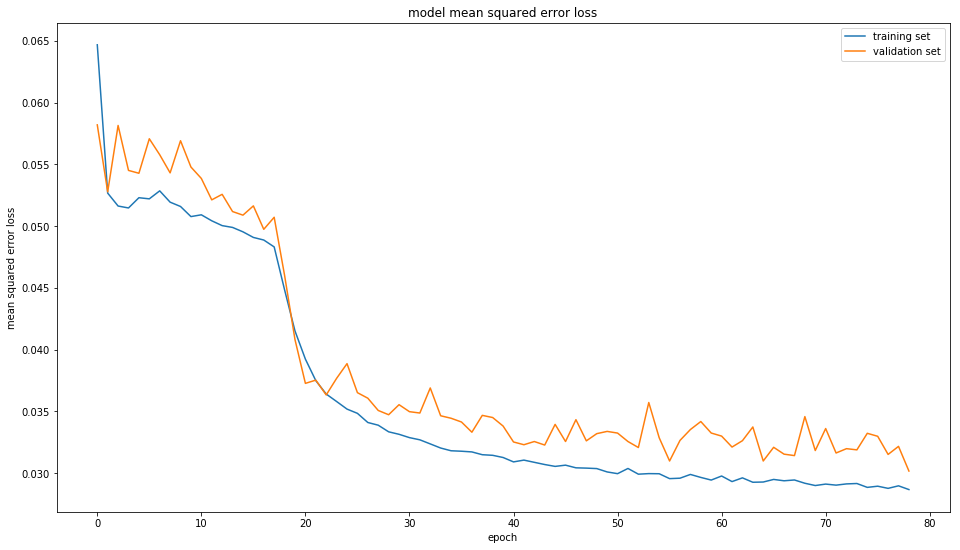

In [8]:
print(history_object.history.keys())
plt.rcParams['figure.figsize'] = (16, 9)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'][1:])
plt.plot(history_object.history['val_loss'][1:])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [9]:
model.save('./models/t1/final_model.h5')